User Engagement analysis

In [2]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
os.chdir('..')
from db_connection.connection import PostgresConnection

from src.utils import missing_values_table, convert_bytes_to_megabytes




Connected to PostgreSQL database!
      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L77566A  ...         

In [3]:
db = PostgresConnection(dbname='postgres', user='postgres', password='ocho')
db.connect()
# Example query
query = "SELECT * FROM xdr_data"
result = db.execute_query(query)

# Convert the result to a Pandas DataFrame
df = pd.DataFrame(result, columns=[desc[0] for desc in db.cursor.description])
print(df.head())  # Display the first few rows of the DataFrame

# Close the connection when done
db.close_connection()


Connected to PostgreSQL database!
      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L77566A  ...         

In [31]:

# Aggregate the engagement metrics per customer id (MSISDN)
engagement_metrics = df.groupby('MSISDN/Number').agg({
    'Start': 'count',  # sessions frequency
    'Dur. (ms).1': 'sum',  # session duration
    'Total UL (Bytes)': 'sum',  # total upload traffic
    'Total DL (Bytes)': 'sum'  # total download traffic
})
engagement_metrics.columns = ['Sessions Frequency', 'Session Duration', 'Total Upload Traffic', 'Total Download Traffic']

In [32]:
# Report the top 10 customers per engagement metric
top_10_sessions_freq = engagement_metrics.sort_values('Sessions Frequency', ascending=False).head(10)
top_10_session_dur = engagement_metrics.sort_values('Session Duration', ascending=False).head(10)
top_10_total_upload = engagement_metrics.sort_values('Total Upload Traffic', ascending=False).head(10)
top_10_total_download = engagement_metrics.sort_values('Total Download Traffic', ascending=False).head(10)

In [33]:
# Display the top 10 customers per engagement metric
print("Top 10 Customers per Sessions Frequency:")
print(top_10_sessions_freq)
print("\nTop 10 Customers per Session Duration:")
print(top_10_session_dur)
print("\nTop 10 Customers per Session Upload Traffic:")
print(top_10_total_upload)
print("\nTop 10 Customers per Session Download Traffic:")
print(top_10_total_download)


Top 10 Customers per Sessions Frequency:
               Sessions Frequency  Session Duration  Total Upload Traffic  \
MSISDN/Number                                                               
3.362632e+10                   18      8.791937e+09           669650721.0   
3.362578e+10                   17      1.855376e+10           729577380.0   
3.361489e+10                   17      9.966906e+09           689483001.0   
3.365973e+10                   16      4.035436e+09           624260321.0   
3.376054e+10                   15      9.279442e+09           703478581.0   
3.367588e+10                   15      4.865954e+09           581568792.0   
3.366716e+10                   13      8.744922e+09           566326364.0   
3.362708e+10                   12      4.703519e+09           445251947.0   
3.360452e+10                   12      5.207995e+09           391775856.0   
3.376041e+10                   12      5.321674e+09           521518890.0   

               Total Download Traf

In [34]:
# Normalize each engagement metric
normalized_engagement_metrics = (engagement_metrics - engagement_metrics.min()) / (engagement_metrics.max() - engagement_metrics.min())

In [35]:
# Run k-means clustering (k=3) on normalized engagement metrics

kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(normalized_engagement_metrics)

In [36]:
# Add cluster labels to the engagement metrics dataframe
engagement_metrics['Cluster'] = clusters

In [37]:
# Compute the minimum, maximum, average, and total non-normalized metrics for each cluster
cluster_metrics = engagement_metrics.groupby('Cluster').agg({
    'Sessions Frequency': ['min', 'max', 'mean', 'sum'],
    'Session Duration': ['min', 'max', 'mean', 'sum'],
    'Total Upload Traffic': ['min', 'max', 'mean', 'sum'],
    'Total Download Traffic': ['min', 'max', 'mean', 'sum']
})

In [38]:
# Aggregate user total traffic per application
application_traffic = df.groupby('MSISDN/Number').agg({
    'Social Media DL (Bytes)': 'sum',
    'Social Media UL (Bytes)': 'sum',
    'Google DL (Bytes)': 'sum',
    'Google UL (Bytes)': 'sum',
    'Email DL (Bytes)': 'sum',
    'Email UL (Bytes)': 'sum',
    'Youtube DL (Bytes)': 'sum',
    'Youtube UL (Bytes)': 'sum',
    'Netflix DL (Bytes)': 'sum',
    'Netflix UL (Bytes)': 'sum',
    'Gaming DL (Bytes)': 'sum',
    'Gaming UL (Bytes)': 'sum',
    'Other DL (Bytes)': 'sum',
    'Other UL (Bytes)': 'sum'
})


In [39]:
# Derive the top 10 most engaged users per application
top_10_social_media = application_traffic.sort_values('Social Media DL (Bytes)', ascending=False).head(10)
top_10_google = application_traffic.sort_values('Google DL (Bytes)', ascending=False).head(10)
top_10_email = application_traffic.sort_values('Email DL (Bytes)', ascending=False).head(10)

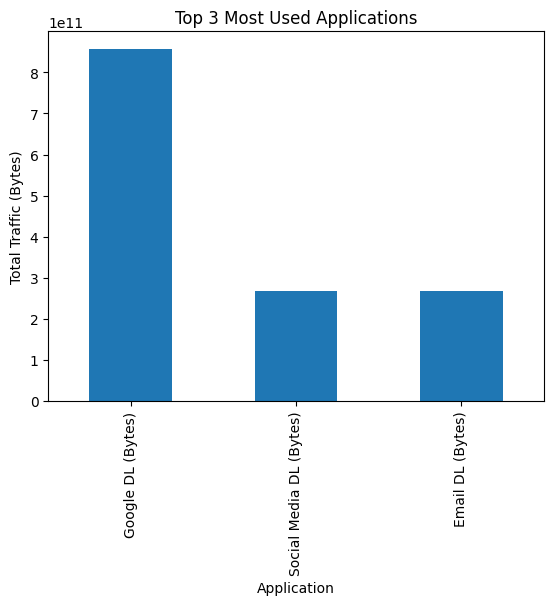

In [40]:
# Plot the top 3 most used applications
top_3_applications = application_traffic[['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)']].sum().nlargest(3)
top_3_applications.plot(kind='bar', xlabel='Application', ylabel='Total Traffic (Bytes)', title='Top 3 Most Used Applications')

plt.show()